## Configure Defaults:

In [1]:
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

# Setup Environment

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

# DataSet

### 1. Generate Data

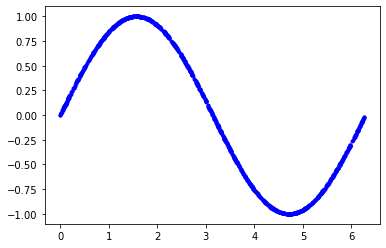

In [3]:
SAMPLES = 1000

x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)
np.random.shuffle(x_values)

y_values = np.sin(x_values).astype(np.float32)

plt.plot(x_values, y_values, 'b.')
plt.show()

### 2. Add Noise

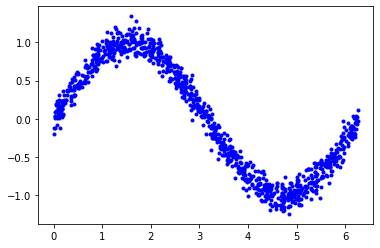

In [4]:
y_values += 0.1 * np.random.randn(*y_values.shape)

plt.plot(x_values, y_values, 'b.')
plt.show()

### 3. Split the Data

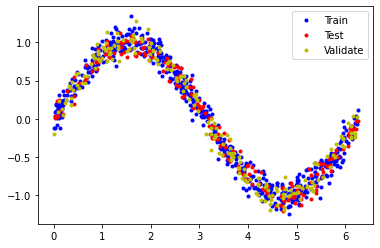

In [5]:
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

assert (x_train.size + x_validate.size + x_test.size) == SAMPLES

plt.plot(x_train, y_train, 'b.', label='Train')
plt.plot(x_test, y_test, 'r.', label='Test')
plt.plot(x_validate, y_validate, 'y.', label='Validate')
plt.legend()
plt.show()

# Training

### 1. Design the Model

In [6]:
model_1 = tf.keras.Sequential()
model_1.add(keras.layers.Dense(8, activation='relu', input_shape=(1,)))
model_1.add(keras.layers.Dense(1))
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

### 2. Train the Model

In [7]:
history_1 = model_1.fit(x_train, y_train, batch_size=64, epochs=500,
                        validation_data=(x_validate, y_validate))

Epoch 1/500
10/10 [==============================] - 1s 20ms/step - loss: 0.6922 - mae: 0.6886 - val_loss: 0.6401 - val_mae: 0.6504
Epoch 2/500
10/10 [==============================] - 0s 3ms/step - loss: 0.5949 - mae: 0.6247 - val_loss: 0.5587 - val_mae: 0.6031
Epoch 3/500
10/10 [==============================] - 0s 5ms/step - loss: 0.5225 - mae: 0.5816 - val_loss: 0.5014 - val_mae: 0.5763
Epoch 4/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4734 - mae: 0.5554 - val_loss: 0.4632 - val_mae: 0.5615
Epoch 5/500
10/10 [==============================] - 0s 3ms/step - loss: 0.4395 - mae: 0.5390 - val_loss: 0.4386 - val_mae: 0.5536
Epoch 6/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4178 - mae: 0.5305 - val_loss: 0.4227 - val_mae: 0.5490
Epoch 7/500
10/10 [==============================] - 0s 3ms/step - loss: 0.4034 - mae: 0.5245 - val_loss: 0.4125 - val_mae: 0.5464
Epoch 8/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3942 - 

### 3. Plot Metrics

**1. Loss (or Mean Squared Error)**

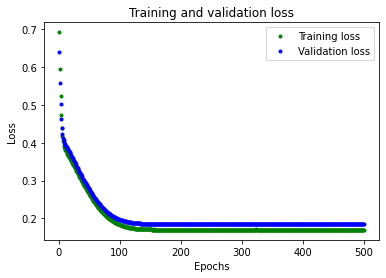

In [8]:
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Exclude the first few epochs so the graph is easier to read

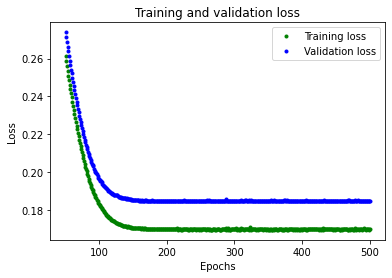

In [9]:
SKIP = 50
plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**2. Mean Absolute Error**

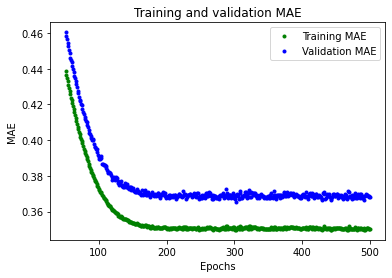

In [10]:
plt.clf()

train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

**3. Actual vs Predicted Outputs**

7/7 [==============================] - 0s 2ms/step - loss: 0.1627 - mae: 0.3434


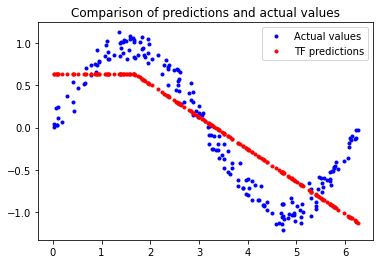

In [11]:
test_loss, test_mae = model_1.evaluate(x_test, y_test)

y_test_pred = model_1.predict(x_test)

plt.clf();
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

# Train a Larger Model

### 1. Design the Model

In [12]:
model = tf.keras.Sequential()
model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

### 2.Train the Model

In [13]:
history = model.fit(x_train, y_train, batch_size=64, epochs=500,
                    validation_data=(x_validate, y_validate))

model.save(MODEL_TF)

Epoch 1/500
10/10 [==============================] - 0s 17ms/step - loss: 0.4227 - mae: 0.5504 - val_loss: 0.4315 - val_mae: 0.5685
Epoch 2/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4077 - mae: 0.5508 - val_loss: 0.4157 - val_mae: 0.5581
Epoch 3/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3908 - mae: 0.5330 - val_loss: 0.3988 - val_mae: 0.5444
Epoch 4/500
10/10 [==============================] - 0s 4ms/step - loss: 0.3760 - mae: 0.5199 - val_loss: 0.3834 - val_mae: 0.5350
Epoch 5/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3606 - mae: 0.5097 - val_loss: 0.3684 - val_mae: 0.5257
Epoch 6/500
10/10 [==============================] - 0s 4ms/step - loss: 0.3457 - mae: 0.5008 - val_loss: 0.3532 - val_mae: 0.5166
Epoch 7/500
10/10 [==============================] - 0s 4ms/step - loss: 0.3303 - mae: 0.4896 - val_loss: 0.3369 - val_mae: 0.5055
Epoch 8/500
10/10 [==============================] - 0s 5ms/step - loss: 0.3142 - 

### 3. Plot Metrics

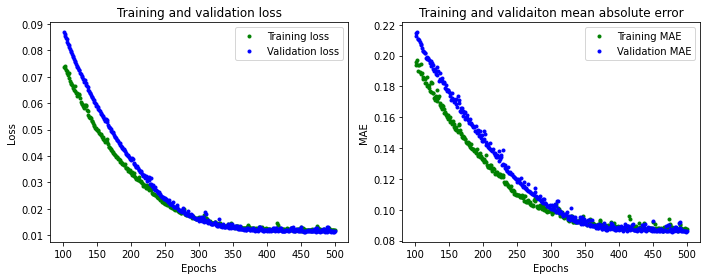

In [14]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validaiton mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

7/7 [==============================] - 0s 2ms/step - loss: 0.0102 - mae: 0.0815


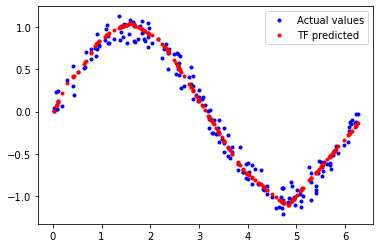

In [15]:
test_loss, test_mae = model.evaluate(x_test, y_test)

y_test_pred = model.predict(x_test)

plt.clf()
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

# Generate a TensorFlow Lite Model

### 1. Generate Models with or without Quantization

In [16]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)

# convert the model to the TensorFlow Lite format without quantization
model_no_quant_tflite = converter.convert()
# save the model to disk
open(MODEL_NO_QUANT_TFLITE, 'wb').write(model_no_quant_tflite)

# convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
# set the optimization flag
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# provide a representative dataset to ensure we quantize correctly
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()
# save the model to disk
open(MODEL_TFLITE, 'wb').write(model_tflite)

2312

### 2. Compare Model Performance

**Helper functions**

In [17]:
def predict_tflite(tflite_model, x_test):
  # prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # if required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])

  # invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

  # if required, dequantize the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

**1. Predictions**

In [18]:
# calculate predictions
y_pred_tf = model.predict(x_values)
y_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_values)
y_pred_tflite = predict_tflite(model_tflite, x_values)

<Figure size 432x288 with 0 Axes>

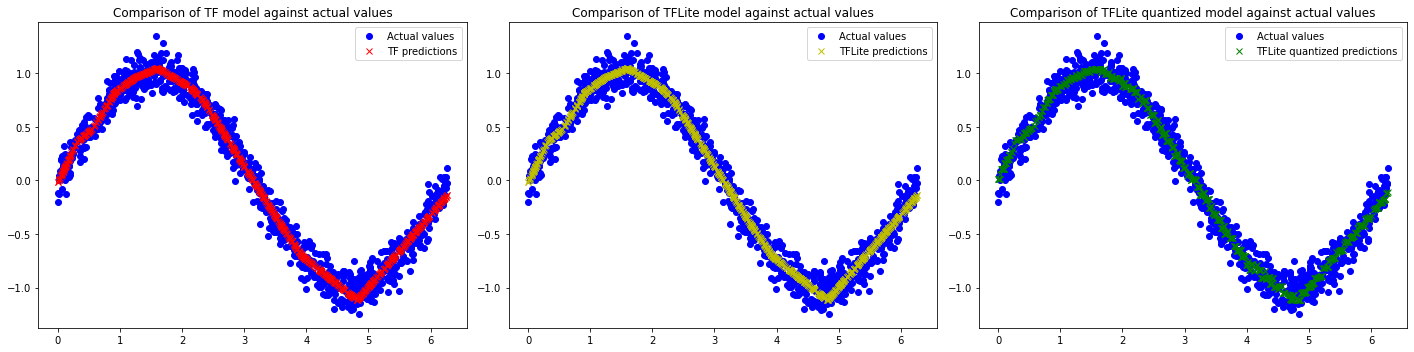

In [29]:
# compare predictions
plt.clf()
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.title('Comparison of TF model against actual values')
plt.plot(x_values, y_values, 'bo', label='Actual values')
plt.plot(x_values, y_pred_tf, 'rx', label='TF predictions')
plt.legend()

plt.subplot(1, 3, 2)
plt.title('Comparison of TFLite model against actual values')
plt.plot(x_values, y_values, 'bo', label='Actual values')
plt.plot(x_values, y_pred_no_quant_tflite, 'yx', label='TFLite predictions')
plt.legend()

plt.subplot(1, 3, 3)
plt.title('Comparison of TFLite quantized model against actual values')
plt.plot(x_values, y_values, 'bo', label='Actual values')
plt.plot(x_values, y_pred_tflite, 'gx', label='TFLite quantized predictions')
plt.legend()

plt.tight_layout()

**2. Loss (MSE/Mean Squared Error)**

In [33]:
# calculate loss
loss_tf, _ = model.evaluate(x_values, y_values, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_values, y_values)
loss_tflite = evaluate_tflite(model_tflite, x_values, y_values)

In [38]:
# compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TensorFlow Lite", loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_tflite]],
     columns=["Model", "Loss/MSE"], index="Model").round(4)
df

,Loss/MSE
Model,
TensorFlow,0.0113
TensorFlow Lite,0.0113
TensorFlow Lite Quantized,0.0119


**3. Size**

In [39]:
# calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [40]:
# compare size
df = pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns=["Model", "Size", ""], index="Model")
df

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,2948 bytes,(reduced by 1148 bytes)
TensorFlow Lite Quantized,2312 bytes,(reduced by 636 bytes)


# Generate a TensorFlow Lite for Microcontrollers Model

In [41]:
# install xxd if it is not available
! apt-get update && apt-get -qq install xxd
# convert to C source file, i.e, a TensorFlow Lite for Microcontrollers Model
! xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# update the vaiable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
! sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [510 kB]
Hit:12 http://ppa.launchpad.net

In [42]:
# print the C source file
! cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x4c, 0x00, 0x00, 0x00,
  0xa0, 0x02, 0x00, 0x00, 0xb0, 0x02, 0x00, 0x00, 0xac, 0x08, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x08, 0x00, 0x00, 0x00, 0x0b, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74,
  0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x50, 0x02, 0x00, 0x00, 0x48, 0x02, 0x00, 0x00,
  0x28, 0x02, 0x00, 0x00, 0xd0, 0x01, 0x00, 0x00, 0xc0, 0x00, 0x00, 0x00,
  0x70, 0x00, 0x00, 0x00, 0x50, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x34, 0x